In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.extmath import safe_sparse_dot
from scipy.sparse import vstack

from matchers import metrics, utils, dataset

In [3]:
np.set_printoptions(suppress=True)
tqdm.pandas()

### Load and process data

In [4]:
# Only need to run this once
# It we split the data into train/test and will persist the data on disk
# dataset.load_split_init(test_size=0.1)

In [5]:
train, test = dataset.load_process_from_disk()

input_names_train, weighted_relevant_names_train, all_candidates_train = train
input_names_test, weighted_relevant_names_test, all_candidates_test = test

all_candidates = np.concatenate((all_candidates_train, all_candidates_test))

### Model

In [6]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), analyzer='char_wb', min_df=10, max_df=0.5)

In [7]:
X_train = vectorizer.fit_transform(all_candidates_train)
X_test = vectorizer.transform(all_candidates_test)
X_all = vstack((X_train, X_test))

#### Similarity Function

In [8]:
def get_similars(name, k=10, demo_mode=False):
    if demo_mode:
        name = utils.add_padding(name)
    x = vectorizer.transform([name]).toarray()
    scores = safe_sparse_dot(X_all, x.T).flatten()
    sorted_scores_idx = np.argsort(scores)[::-1][:k]
    candidates = all_candidates[sorted_scores_idx]
    if demo_mode:
        candidates = [utils.remove_padding(candidate) for candidate in candidates]
    candidates_scores = scores[sorted_scores_idx]
    
    return list(zip(candidates, candidates_scores))

#### Demo

In [9]:
get_similars('schumacher', 10, True)

[('schumacker', 0.8091910201105204),
 ('schuman', 0.7499740328601138),
 ('schumann', 0.7028078364574786),
 ('schumaker', 0.691594961530637),
 ('schacher', 0.6555404281281796),
 ('schum', 0.6374145590188357),
 ('scheuman', 0.5581458870921694),
 ('hamacher', 0.5427420219299985),
 ('amacher', 0.5366064690591383),
 ('stelmacher', 0.5298472894115192)]

### Generate candidates for all test names

In [10]:
k = 100 # Number of candidates to consider
name_candidates = list(map(lambda x: get_similars(x, k=k), tqdm(input_names_test)))

100%|██████████| 2452/2452 [00:08<00:00, 302.91it/s]


In [11]:
len(name_candidates)

2452

In [12]:
candidates = np.array(name_candidates, dtype=[('name','O'),('score', 'f8')])

### Evaluation

### mAP@0.8

In [13]:
metrics.avg_precision_at_threshold(weighted_relevant_names_test, candidates, 0.8)

0.6938893420337139

### mAP@0.5

In [14]:
metrics.avg_precision_at_threshold(weighted_relevant_names_test, candidates, 0.5)

0.19117343262179495

### Precision-Recall Curve

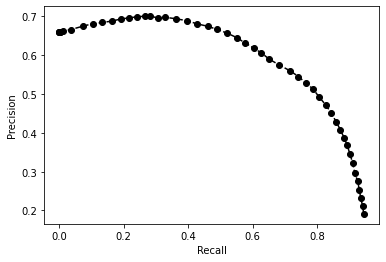

In [15]:
# minimum score threshold to test
min_threshold = 0.5
metrics.precision_recall_curve_at_threshold(weighted_relevant_names_test, candidates, min_threshold)

### Test

In [16]:
weighted_relevant_names_test[8]

[('<abraham>', 1.0)]

In [17]:
candidates[8][:5]

array([('<abrahams>', 1.        ), ('<abraham>', 0.7997712 ),
       ('<abrahart>', 0.70755729), ('<abram>', 0.54115503),
       ('<mathams>', 0.46421162)], dtype=[('name', 'O'), ('score', '<f8')])

In [18]:
metrics.recall_at_threshold(weighted_relevant_names_test[8], candidates[8], 0.77)

1.0

In [19]:
metrics.recall_at_threshold(weighted_relevant_names_test[8], candidates[8], 0.71)

1.0